In [1]:
%matplotlib inline

import pickle
import copy
import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import networkx as nx
import xgboost as xgb
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('./data/twitch_final_dataset.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head(5)

,Source,Destination,Class,Page_Rank_Src,Page_Rank_Dst,Shortest_Path,Follows_Back,Followers_Src,Followees_Src,Followers_Dst,Followees_Dst,Int_Followers,Int_Followees
0,6194,255,1,0.000033,0.000015,-1,0,0,4,0,3,0,0
1,6194,980,1,0.000033,0.000016,-1,0,0,4,0,15,0,1
2,6194,2992,1,0.000033,0.000017,4,0,0,4,3,0,0,0
3,6194,2507,1,0.000033,0.000043,3,0,0,4,8,13,0,0
4,6194,986,1,0.000033,0.000020,8,0,0,4,1,18,0,0


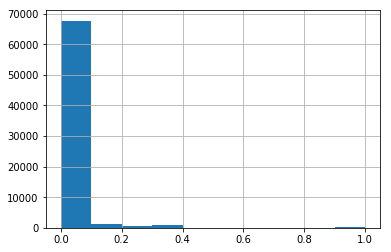

In [3]:
x = df['Page_Rank_Src']
df['Page_Rank_Src'] = ( x-x.min()) / ( x.max() - x.min() )
df['Page_Rank_Src'].hist()

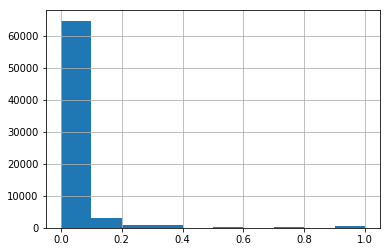

In [4]:
x = df['Page_Rank_Dst']
df['Page_Rank_Dst'] = ( x-x.min()) / ( x.max() - x.min() )
df['Page_Rank_Dst'].hist()

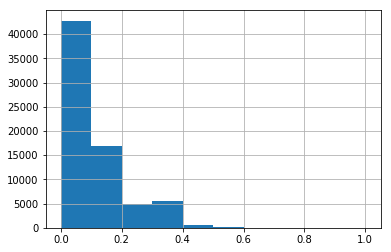

In [5]:
x = df['Shortest_Path']
df['Shortest_Path'] = ( x-x.min()) / ( x.max() - x.min() )
df['Shortest_Path'].hist()

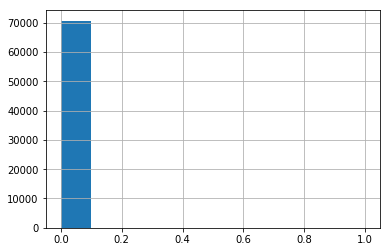

In [6]:
x = df['Follows_Back']
df['Follows_Back'] = ( x-x.min()) / ( x.max() - x.min() )
df['Follows_Back'].hist()

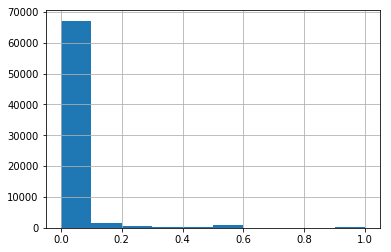

In [7]:
x = df['Followees_Dst']
df['Followees_Dst'] = ( x-x.min()) / ( x.max() - x.min() )
df['Followees_Dst'].hist()

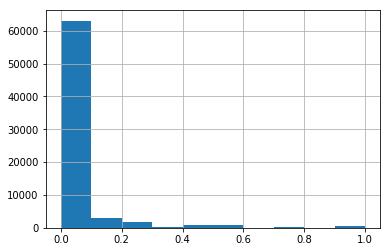

In [8]:
x = df['Followees_Src']
df['Followees_Src'] = ( x-x.min()) / ( x.max() - x.min() )
df['Followees_Src'].hist()

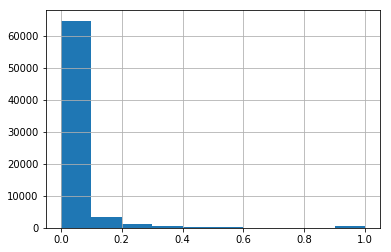

In [9]:
x = df['Followers_Dst']
df['Followers_Dst'] = ( x-x.min()) / ( x.max() - x.min() )
df['Followers_Dst'].hist()

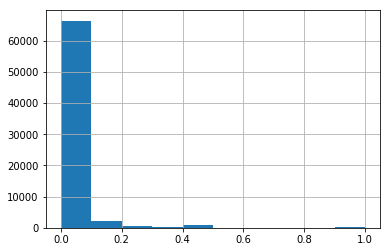

In [10]:
x = df['Followers_Src']
df['Followers_Src'] = ( x-x.min()) / ( x.max() - x.min() )
df['Followers_Src'].hist()

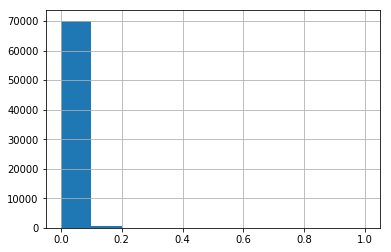

In [11]:
x = df['Int_Followees']
df['Int_Followees'] = ( x-x.min()) / ( x.max() - x.min() )
df['Int_Followees'].hist()

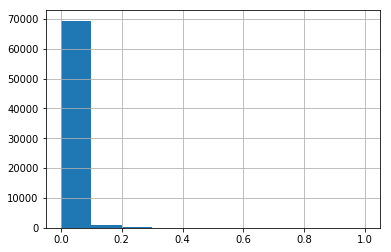

In [12]:
x = df['Int_Followers']
df['Int_Followers'] = ( x-x.min()) / ( x.max() - x.min() )
df['Int_Followers'].hist()

In [13]:
df.head(5)

,Source,Destination,Class,Page_Rank_Src,Page_Rank_Dst,Shortest_Path,Follows_Back,Followers_Src,Followees_Src,Followers_Dst,Followees_Dst,Int_Followers,Int_Followees
0,6194,255,1,0.013325,0.002871,0.000000,0.0,0.0,0.01,0.0000,0.0075,0.0,0.000000
1,6194,980,1,0.013325,0.003198,0.000000,0.0,0.0,0.01,0.0000,0.0375,0.0,0.013158
2,6194,2992,1,0.013325,0.004148,0.217391,0.0,0.0,0.01,0.0075,0.0000,0.0,0.000000
3,6194,2507,1,0.013325,0.018890,0.173913,0.0,0.0,0.01,0.0200,0.0325,0.0,0.000000
4,6194,986,1,0.013325,0.005404,0.391304,0.0,0.0,0.01,0.0025,0.0450,0.0,0.000000


In [14]:
df.to_csv('./data/twitch_preprocessed_data.csv')

In [15]:
g = nx.from_pandas_edgelist(df[['Source','Destination']], source='Source', target='Destination',create_using=nx.DiGraph())
print nx.info(g)

Name: 
Type: DiGraph
Number of nodes: 50107
Number of edges: 70648
Average in degree:   1.4099
Average out degree:   1.4099


In [16]:
df_x = df.drop(columns=['Source', 'Destination', 'Class'])
df_y = df[['Class']]
x_train, x_test, y_train, y_test  = train_test_split(df_x, df_y, test_size = 0.3, random_state=7)

## 1. Logistic Regression

In [17]:
penalty_values = ['l1', 'l2']
c_values = np.logspace(0, 4, 10)
param_grid = {'C' : c_values, 'penalty' : penalty_values}

gs_lr = GridSearchCV(cv = 10, estimator = LogisticRegression(), param_grid = param_grid)

In [18]:
start = time.time()
gs_lr.fit(x_train, y_train)
end = time.time()
print 'Time taken to train model : ', round(end-start,2) , ' seconds'

Time taken to train model :  18.56  seconds


In [19]:
pickle.dump(gs_lr.best_estimator_, open('./data/twitch_lr_model.p', 'wb'))
print gs_lr.best_params_

{'penalty': 'l1', 'C': 2.7825594022071245}


In [20]:
print classification_report(gs_lr.best_estimator_.predict(x_test), y_test) 

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     11208
           1       0.92      0.98      0.95      9987

   micro avg       0.95      0.95      0.95     21195
   macro avg       0.95      0.95      0.95     21195
weighted avg       0.95      0.95      0.95     21195



In [21]:
print confusion_matrix(gs_lr.best_estimator_.predict(x_test), y_test) 

[[10319   889]
 [  201  9786]]


## 2. Random Forest

In [22]:
estimators = [50, 100, 150]
depths = [9, 12, 15, 24]
split = np.random.randint(100, 150, 2)
leaves = np.random.randint(20, 30, 2)
param_grid = {'n_estimators' : estimators, 'max_depth' : depths, 'min_samples_split' : split, 'min_samples_leaf' : leaves}

gs_rf = GridSearchCV(cv = 10, estimator = RandomForestClassifier(), param_grid = param_grid)

In [23]:
start = time.time()
gs_rf.fit(x_train, y_train) 
end = time.time()
print 'Time taken to train model : ', round(end-start,2) , ' seconds'

Time taken to train model :  1023.86  seconds


In [24]:
pickle.dump(gs_rf.best_estimator_, open('./data/twitch_rf_model.p', 'wb')) 
print gs_rf.best_params_

{'min_samples_split': 125, 'n_estimators': 100, 'max_depth': 9, 'min_samples_leaf': 25}


In [25]:
print classification_report(gs_rf.best_estimator_.predict(x_test), y_test) 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10795
           1       0.96      0.98      0.97     10400

   micro avg       0.97      0.97      0.97     21195
   macro avg       0.97      0.97      0.97     21195
weighted avg       0.97      0.97      0.97     21195



In [26]:
print confusion_matrix(gs_rf.best_estimator_.predict(x_test), y_test) 

[[10318   477]
 [  202 10198]]


## 3. SVM

In [27]:
kernels = ['rbf', 'linear']
c_values = [0.001, 0.01, 0.1, 1]
param_grid = {'kernel':kernels, 'C':c_values}

gs_svm = GridSearchCV(cv=10, estimator=svm.SVC(), param_grid=param_grid)

In [28]:
start = time.time()
gs_svm.fit(x_train, y_train)
end = time.time()
print 'Time taken to train model : ', round(end-start,2) , ' seconds'

Time taken to train model :  3517.65  seconds


In [36]:
pickle.dump(gs_svm.best_estimator_, open('./data/twitch_svm_model.p', 'wb'))
print gs_svm.best_params_

{'kernel': 'linear', 'C': 1}


In [30]:
print classification_report(gs_svm.best_estimator_.predict(x_test), y_test)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     11527
           1       0.89      0.99      0.94      9668

   micro avg       0.94      0.94      0.94     21195
   macro avg       0.94      0.94      0.94     21195
weighted avg       0.94      0.94      0.94     21195



In [31]:
print confusion_matrix(gs_svm.best_estimator_.predict(x_test), y_test)

[[10379  1148]
 [  141  9527]]


## 4. KGBoost

In [32]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate = 0.02, n_estimators = 600, objective = 'binary:logistic', silent = True, nthread = 1)
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
gs_xgb = GridSearchCV(xgb, param_grid=params, n_jobs = 4, cv = skf.split(x_train,y_train), verbose=3)
gs_xgb.fit(x_train, y_train)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 15.3min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 28.5min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 46.8min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed: 70.9min
[Parallel(n_jobs=4)]: Done 1215 out of 1215 | elapsed: 75.8min finished


GridSearchCV(cv=<generator object split at 0x1a1f6cfe10>,
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'gamma': [0.5, 1, 1.5, 2, 5], 'min_child_weight': [1, 5, 10], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [33]:
pickle.dump(gs_xgb.best_estimator_, open('./data/twitch_xgb_model.p', 'wb'))
print gs_xgb.best_params_

{'subsample': 0.6, 'colsample_bytree': 0.8, 'max_depth': 5, 'gamma': 1, 'min_child_weight': 1}


In [34]:
print(classification_report(gs_xgb.best_estimator_.predict(x_test), y_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10795
           1       0.96      0.98      0.97     10400

   micro avg       0.97      0.97      0.97     21195
   macro avg       0.97      0.97      0.97     21195
weighted avg       0.97      0.97      0.97     21195



In [35]:
print(confusion_matrix(gs_xgb.best_estimator_.predict(x_test), y_test))

[[10316   479]
 [  204 10196]]
